# 02_Análisis y preprocesamiento de metadatos clínicos (TCGA_BRCA)

## Introducción técnica del notebook

**Autor:** Javier García Delgado

**Fecha:** 24 de mayo de 2025

**Proyecto:** Análisis RNA_seq de cáncer de mama (TCGA_BRCA)

Notebook 2 de 5

En este notebook se lleva a cabo el análisis exploratorio y preprocesamiento de los metadatos clínicos asociados a las muestras de expresión génica. Continuando el análisis iniciado en el notebook 1 (EDA).

Los objetivos principales son:

- Explorar y comprender la distribución de variables clínicas clave.
- Seleccionar aquellas variables relevantes para futuros análisis.
- Codificar y normalizar variables si es necesario.
- Preparar un subconjunto de metadatos que pueda integrarse posteriormente con los datos de expresión.

Este paso es crucial para garantizar la calidad y coherencia de los análisis posteriores.


## Índice del Notebook 2

1. Carga de datos clínicos y contexto
2. Revisión general del metadata y planificación del análisis clínico
3. Filtrado de muestras por tipo biológico
4. Análisis de variables clave:
   - 4.1 sample_type
   - 4.2 age_at_pathologic_diagnosis
   - 4.3 pathologic_stage
   - 4.4 vital_status
   - 4.5 gender
5. Codificación y agrupación de variables
6. Preparación del subconjunto final de metadatos
7. Guardado del dataframe limpio para próximos notebooks


## 1. Carga de datos clínicos

Cargamos el archivo de metadatos clínicos previamente descargado desde UCSC Xena y lo volvemos a revisar de forma independiente, centrándonos en las variables potencialmente útiles para análisis posteriores.

In [1]:
# Cargar paquetes
import pandas as pd

# Cargar subconjuntos filtrados desde archivo
meta_filtrado = pd.read_csv("data/meta_filtrado.tsv", sep="\t", index_col=0)
exp_filtrado = pd.read_csv("data/exp_filtrado.tsv", sep="\t", index_col=0)

# Verificar dimensiones
print("Metadatos clínicos:", meta_filtrado.shape)
print("Expresión génica:", exp_filtrado.shape)

Metadatos clínicos: (1218, 193)
Expresión génica: (1218, 20530)


## 2. Revisión general del metadata y planificación del análisis clínico

Antes de realizar análisis individuales de variables, se examinan las columnas disponibles en el metadata filtrado.  
Esto permite identificar variables clínicas, técnicas y moleculares potencialmente útiles, y planificar cuáles analizar en detalle según su relevancia biológica, completitud y trazabilidad.

Las variables seleccionadas para análisis individual en este notebook son:
- `sample_type` (tipo biológico de muestra)
- `age_at_initial_pathologic_diagnosis` (edad al diagnóstico)
- `pathologic_stage` (estadio tumoral)
- `vital_status` (estado vital)
- `gender` (sexo biológico)

Estas se exploran en la Sección 4 de forma individual. La elección de estas variables se justifica n su correspondiente bloque, basándose en su utilidad clínica o biomédica, su frecuencia de uso en estudios transcriptómicos (como TCGA-BRCA), y su potencial valor en análisis de expresión génica, estratificación o modelos supervisados.

## 3. Filtrado de muestras por tipo biológico

Seleccionamos únicamente las muestras clasificadas como `Primary Tumor` o `Solid Tissue Normal` (tejido normal adyacente no tumoral). 

Esta elección responde al diseño clásico de comparación entre tejido tumoral y su contrapartida normal, lo que permite detectar genes diferencialmente expresados relevantes para el desarrollo del cáncer.

Excluir otros tipos de muestras disponibles en TCGA (como metástasis, tumores recurrentes o tejidos sanguíneos) es fundamental para evitar introducir sesgos o variabilidad no deseada en el análisis, ya que representan condiciones biológicas diferentes que podrían distorsionar los resultados. Este paso garantiza que las comparaciones sean consistentes y que las conclusiones extraídas reflejen con mayor precisión los mecanismos moleculares implicados en la transformación tumoral.

In [4]:
# Filtrar metadatos por tipo de muestra deseado
tipos_validos = ['Primary Tumor', 'Solid Tissue Normal']
meta_filtrado = meta_filtrado[meta_filtrado['sample_type'].isin(tipos_validos)]

# Obtener los IDs de las muestras seleccionadas
ids_filtrados = meta_filtrado.index

# Filtrar expresión para conservar solo esas muestras
exp_filtrado = exp_filtrado.loc[ids_filtrados]

# Verificar formas finales
print("Metadatos filtrados:", meta_filtrado.shape)
print("Expresión filtrada:", exp_filtrado.shape)


Metadatos filtrados: (1211, 193)
Expresión filtrada: (1211, 20530)


Tras el filtrado, ambos conjuntos contienen 1211 muestras, lo que confirma que: 

- La selección por tipo biológico se ha aplicado correctamente, reteniendo únicamente muestras de tumor primario y tejido normal sólido.

- Los metadatos y la matriz de expresión están correctamente alineados y listos para análisis conjuntos, como clasificación, clustering, etc.

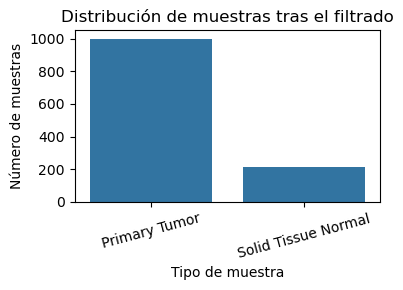

In [11]:
data = {'sample_type': ['Primary Tumor'] * 1000 + ['Solid Tissue Normal'] * 211}
metadata_filtrado = pd.DataFrame(data)

# Crear un countplot para visualizar la distribución de tipos de muestra
plt.figure(figsize=(4, 3))
sns.countplot(data=metadata_filtrado, x='sample_type')
plt.title('Distribución de muestras tras el filtrado')
plt.xlabel('Tipo de muestra')
plt.ylabel('Número de muestras')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

La visualización confirma que, tras el filtrado, el conjunto de datos está compuesto mayoritariamente por muestras de **tumor primario**, con una proporción menor de **tejido normal sólido**. Esta distribución es coherente con la naturaleza de los estudios oncológicos en cohortes como TCGA, donde el muestreo tumoral es más abundante.

Aunque el número de muestras normales es menor, sigue siendo suficiente para realizar comparaciones estadísticas y extraer conclusiones válidas sobre diferencias en la expresión génica. Esta diferencia en tamaños de muestra se tendrá en cuenta en los análisis posteriores (por ejemplo, al aplicar métodos que controlen el desequilibrio de clases).


## 4.1. Análisis de la variable 'sample_type'

La variable `sample_type` indica el tipo de tejido del que proviene cada muestra. Es fundamental para los análisis posteriores, ya que nos permite distinguir entre muestras tumorales (`Primary Tumor`), normales (`Solid Tissue Normal`) y posibles metástasis.

En este análisis trabajaremos principalmente con las clases tumorales y normales.

In [2]:
# Ver distribución de tipos de muestra
meta_filtrado['sample_type'].value_counts()


sample_type
Primary Tumor          1097
Solid Tissue Normal     114
Metastatic                7
Name: count, dtype: int64

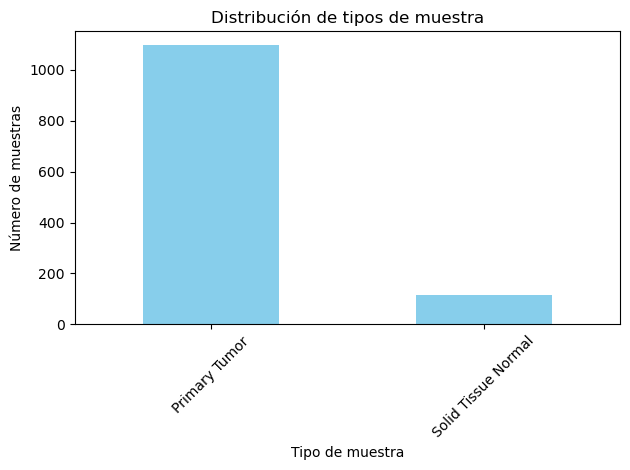

In [13]:
import matplotlib.pyplot as plt

meta_filtrado['sample_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribución de tipos de muestra")
plt.xlabel("Tipo de muestra")
plt.ylabel("Número de muestras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Reflexión 1: Filtrado biológico (`sample_type`)

La decisión de conservar únicamente muestras tumorales primarias y tejido normal adyacente responde a criterios bien establecidos en estudios transcriptómicos comparativos, como los realizados con datos de TCGA.

#### Justificación de la selección

- **Tumores primarios (n = 1097)** constituyen la mayoría del conjunto, y son esenciales para estudiar alteraciones propias del tumor.
- **Tejido normal sólido (n = 114)** actúa como grupo de referencia y permite contrastar perfiles de expresión de forma biológicamente informada.
- **Muestras metastásicas (n = 7)** son escasas y heterogéneas, lo que impide su uso fiable en comparaciones globales. Se excluyen en esta fase para evitar introducir ruido analítico.

#### Importancia del filtrado

Este paso no es meramente técnico:  
- La selección adecuada de los grupos comparativos **define la validez biológica del estudio**.
- Se favorece una estructura clara, reproducible y alineada con la práctica clínica, lo que facilitará la interpretación y publicación de resultados en etapas posteriores.


## 4.2 Análisis de la variable 'age_at_initial_pathologic_diagnosis'

Seleccionamos la variable `'age_at_initial_pathologic_diagnosis_nature2012'` como referencia para la edad al diagnóstico, ya que es la que contiene datos completos y consistentes en esta cohorte.  
Aunque existen otras columnas relacionadas con edad, esta es la más habitual en estudios TCGA y su significado es clínicamente relevante.


In [5]:
# Comprobamos el nombre exacto de la columna para hacer el gráfico
meta_filtrado.columns.to_list()[:5]


['AJCC_Stage_nature2012',
 'Age_at_Initial_Pathologic_Diagnosis_nature2012',
 'CN_Clusters_nature2012',
 'Converted_Stage_nature2012',
 'Days_to_Date_of_Last_Contact_nature2012']

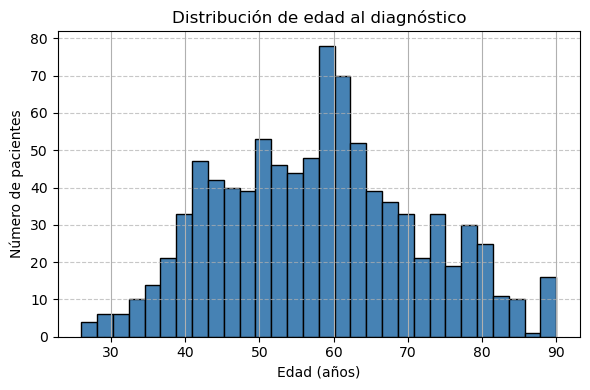

In [6]:
#Gráfico de edad de diagnóstico
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
meta_filtrado['Age_at_Initial_Pathologic_Diagnosis_nature2012'].hist(bins=30, color='steelblue', edgecolor='black')
plt.title("Distribución de edad al diagnóstico")
plt.xlabel("Edad (años)")
plt.ylabel("Número de pacientes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Reflexión 2:

- La distribución de edad al diagnóstico muestra que la mayoría de pacientes se encuentran entre los 45 y 70 años, con un pico claro alrededor de los 60 años.  
Esto constituye un primer **insight** interesante: el mayor número de diagnósticos se da en torno a esa edad, en línea con la epidemiología conocida del cáncer de mama.

- También se observan casos por debajo de los 40 y algunos por encima de los 80, pero en menor proporción.  

- No hay valores extremos que obliguen a limpiar ni transformar la variable.

Más adelante, esta variable podría agruparse (por ejemplo, <50 vs ≥50 años) para estudiar asociaciones con expresión génica u otros subgrupos clínicos.
    

### Reflexión 2: Edad al diagnóstico (`age_at_initial_pathologic_diagnosis`)

La variable `age_at_initial_pathologic_diagnosis` presenta una distribución coherente con la epidemiología del cáncer de mama.

#### Interpretación de la distribución

- La mayoría de los diagnósticos se concentran entre los **45 y 70 años**, con un pico claro alrededor de los **60 años**, lo cual coincide con datos poblacionales conocidos.
- Se detectan también pacientes **menores de 40 años** y **mayores de 80**, aunque en proporciones menores, lo que aporta diversidad clínica sin introducir valores extremos preocupantes.
- **No se identifican outliers clínicamente absurdos**, por lo que la variable puede conservarse en formato numérico continuo sin necesidad de limpieza o transformación inmediata.

#### Posibles usos posteriores

- Esta variable podría **agrupase en categorías clínicas** como `<50` vs `≥50 años`, especialmente si se desea evaluar su relación con expresión génica, respuesta al tratamiento o subgrupos moleculares.
- También puede considerarse como **covariable de ajuste** en modelos supervisados si se observa correlación con otras variables.

En resumen, `age_at_initial_pathologic_diagnosis` es una variable estable y clínicamente interpretable que puede integrarse en múltiples estrategias de análisis.


## 4.3. Análisis de la variable `pathologic_stage`

La variable `pathologic_stage` representa el estadio del cáncer determinado tras cirugía, basado en el sistema de estadificación AJCC (combinando tamaño tumoral, afectación ganglionar y metástasis).  
Se trata de una variable ampliamente utilizada en estudios clínicos oncológicos y proporciona una medida clara de la progresión del tumor.

Esta variable es útil tanto para describir la cohorte como para posibles análisis estratificados (por ejemplo, comparación de expresión génica entre tumores tempranos vs avanzados).

Su elección se fundamenta en:
- Su relevancia clínica documentada en la literatura (por ejemplo, Cancer Genome Atlas Network, *Nature*, 2012).
- Su buena disponibilidad en TCGA.
- Su utilidad como variable explicativa en modelos supervisados o como criterio de agrupación biológica.


In [15]:
# Revisión de valores únicos
meta_filtrado['pathologic_stage'].value_counts(dropna=False)

pathologic_stage
Stage IIA        393
Stage IIB        287
Stage IIIA       173
Stage I          106
Stage IA          90
Stage IIIC        69
Stage IIIB        31
Stage IV          22
Stage X           14
NaN                9
Stage IB           6
Stage II           6
[Discrepancy]      3
Stage III          2
Name: count, dtype: int64

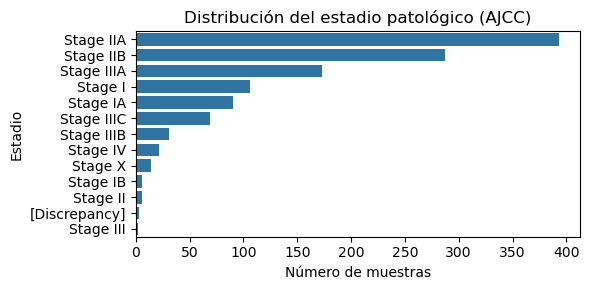

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.countplot(data=meta_filtrado, y='pathologic_stage',
              order=meta_filtrado['pathologic_stage'].value_counts().index)
plt.title('Distribución del estadio patológico (AJCC)')
plt.xlabel('Número de muestras')
plt.ylabel('Estadio')
plt.tight_layout()
plt.show()

### Reflexión 3: Estadio patológico (`pathologic_stage`)

La variable `pathologic_stage` muestra una distribución amplia de estadios, predominando los estadios intermedios (como II y III). Esto refleja una realidad clínica habitual en el diagnóstico del cáncer de mama, donde muchas pacientes son detectadas en fases no muy tempranas, pero aún tratables.

#### Interpretación de la distribución

Este patrón es útil por varias razones:
- Muestra que la cohorte tiene una **heterogeneidad clínica suficiente** como para permitir comparaciones entre diferentes niveles de progresión tumoral.
- Permite **reagrupar los estadios** en categorías clínicas relevantes:
  - *Temprano*: Estadios I–II
  - *Avanzado*: Estadios III–IV
- Tal reagrupación puede facilitar análisis estratificados o modelos supervisados más robustos.

También es importante tener en cuenta:
- Posibles valores nulos o ambiguos (como `Not Reported`), que deben manejarse antes de usar esta variable en análisis cuantitativos.
- Que esta clasificación se basa en hallazgos patológicos tras cirugía, por lo que ofrece un grado de precisión superior al estadio clínico estimado.

#### Visualización

El gráfico confirma una distribución escalonada, con menor representación en los extremos (I y IV). Esta variabilidad es deseable desde el punto de vista analítico, siempre que se controle adecuadamente el número de muestras por grupo al realizar comparaciones.

En conjunto, `pathologic_stage` aporta una dimensión clínica relevante y bien estructurada que se puede usar como variable explicativa o de estratificación en fases posteriores del análisis.


### 4.4. Análisis de la variable `vital_status`

`vital_status` indica si la paciente está viva o fallecida en el momento de la última actualización clínica.  
Es una variable fundamental para análisis de supervivencia (Kaplan–Meier, Cox) y puede servir como variable objetivo en modelos de clasificación si se dispone del tiempo hasta evento.

Se selecciona por:
- Su valor clínico directo y binario.
- Su potencial uso en análisis de supervivencia.
- Su buena completitud en la mayoría de cohortes de TCGA.

Aquí se revisa su distribución para valorar su posible uso posterior.


In [17]:
meta_filtrado['vital_status'].value_counts(dropna=False)


vital_status
LIVING      1012
DECEASED     196
NaN            3
Name: count, dtype: int64

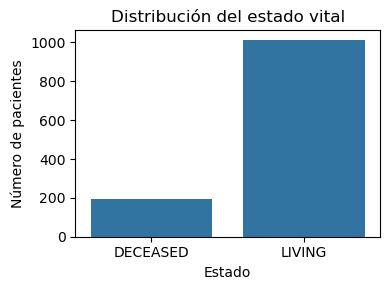

In [18]:
plt.figure(figsize=(4, 3))
sns.countplot(data=meta_filtrado, x='vital_status')
plt.title('Distribución del estado vital')
plt.xlabel('Estado')
plt.ylabel('Número de pacientes')
plt.tight_layout()
plt.show()


#### Reflexión 4: Estado vital y equilibrio de clases

La variable `vital_status` presenta una distribución claramente desbalanceada: la mayoría de pacientes están vivas al momento del último seguimiento, mientras que un grupo menor aparece como fallecido.

Este patrón es esperable en cohortes amplias como TCGA-BRCA, donde muchas pacientes son diagnosticadas en estadios tempranos y la mortalidad es relativamente baja, especialmente si el tiempo de seguimiento es limitado.

#### Interpretación de la distribución

Este desequilibrio tiene implicaciones importantes:
- Si se plantea usar `vital_status` como variable objetivo en modelos supervisados (ej. clasificación), será necesario aplicar técnicas de **balanceo de clases** (submuestreo, sobremuestreo o métodos como SMOTE).
- Si se planea realizar análisis de **supervivencia**, esta variable será útil como censor binario (`0 = viva`, `1 = fallecida`) junto con `OS_Time` (tiempo de seguimiento o hasta el evento).

#### Visualización

El gráfico de barras refuerza visualmente la asimetría de clases. Aunque esperada, es importante tenerla en cuenta desde ahora para evitar conclusiones engañosas en etapas posteriores del análisis.

Este tipo de reflexiones permite anticipar ajustes metodológicos que mejoren la robustez y fiabilidad del estudio.


## 4.5. Análisis de la variable 'gender'

Revisamos la variable `gender` para confirmar la distribución por sexo de las muestras.  
Dado que se trata de cáncer de mama, esperamos una mayoría de pacientes femeninas.  
Detectar posibles muestras masculinas o valores nulos es importante para mantener la coherencia clínica del análisis.
 

In [7]:
# Ver distribución de género
meta_filtrado['gender'].value_counts(dropna=False)


gender
FEMALE    1195
MALE        13
NaN          3
Name: count, dtype: int64

A continuación representamos gráficamente la distribución de género en la cohorte.


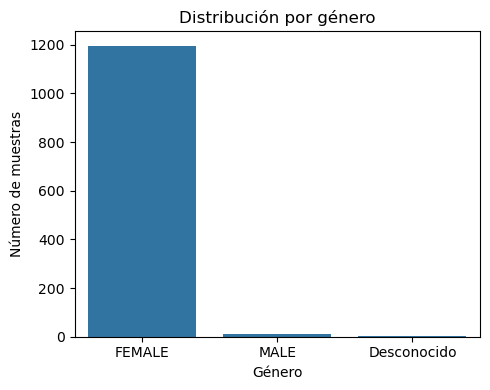

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar variable
meta_filtrado['gender_plot'] = meta_filtrado['gender'].fillna('Desconocido')

# Gráfico de género
plt.figure(figsize=(5, 4))
sns.countplot(data=meta_filtrado, x='gender_plot', order=['FEMALE', 'MALE', 'Desconocido'])
plt.title("Distribución por género")
plt.xlabel("Género")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()


### Reflexión 5: Distribución por género (`gender`)

La variable `gender` muestra una distribución claramente sesgada hacia el sexo femenino, lo cual es completamente esperable en un estudio centrado en cáncer de mama.

#### Interpretación de la distribución

- La **mayoría de las muestras (n ≈ 1195)** pertenecen a pacientes femeninas, lo cual concuerda con la epidemiología conocida del cáncer de mama, que afecta mayoritariamente a mujeres.
- Se identifican **13 muestras clasificadas como masculinas**, lo que representa una minoría esperable, ya que el cáncer de mama en hombres representa menos del 1% de los casos clínicos según la literatura (Fentiman et al., *The Lancet*, 2006).
- Existen además **algunas muestras sin dato (`NaN`)**, que podrían deberse a errores de registro, muestras anónimas o pacientes con género no especificado.

#### Implicaciones analíticas

Aunque el número de muestras masculinas es reducido, **podría introducir sesgos** si no se trata adecuadamente en análisis posteriores:
- En estudios de expresión génica, las diferencias por sexo pueden ser relevantes en ciertos genes ligados a hormonas o vías específicas.
- Por tanto, podría considerarse **excluir las muestras masculinas o analizarlas por separado** si se desea evitar ruido biológico en modelos o comparaciones.

La visualización de la variable confirma este desequilibrio de clases y permite anticipar decisiones de limpieza o segmentación futura.


## 4.6 Compendio de la Sección 4: Análisis de variables clínicas

Tras revisar individualmente las variables seleccionadas del metadata clínico, se pueden destacar las siguientes ideas clave:

- **`sample_type`** permite distinguir entre muestras tumorales y normales. Es la base para el filtrado biológico y posterior análisis diferencial.

- **`age_at_initial_pathologic_diagnosis`** muestra una distribución amplia, compatible con la epidemiología del cáncer de mama. Puede usarse como covariable en análisis posteriores o ser categorizada por intervalos clínicamente relevantes.

- **`pathologic_stage`** presenta una buena heterogeneidad entre estadios I–III. Su clasificación permite reagrupar muestras por progresión tumoral y usarla como variable explicativa o de estratificación.

- **`vital_status`** refleja el estado vital en el último seguimiento. Aunque desbalanceada, puede ser útil como variable objetivo en análisis de supervivencia o clasificación, previa recodificación binaria y/o balanceo de clases.

- **`gender`** confirma que la cohorte es predominantemente femenina, como es esperable en cáncer de mama. La escasa presencia de pacientes masculinos podría considerarse excluible o analizable por separado, si se detectan sesgos asociados.

En conjunto, estas variables aportan información clínica sólida y complementaria que puede ser integrada de forma crítica en etapas posteriores del análisis transcriptómico, como modelos supervisados, agrupamientos o estudios de asociación con expresión génica.


## 5. Codificación y agrupación de variables

En esta sección se realiza la transformación de algunas variables clínicas para facilitar su uso en análisis posteriores.

Las operaciones incluyen:
- **Codificación binaria** de variables categóricas (ej. `vital_status`)
- **Agrupación de estadios clínicos** en categorías más robustas (ej. `pathologic_stage`)
- **Transformación opcional de edad** en rangos si se requiere segmentación clínica

Estas modificaciones buscan mejorar la interpretabilidad, evitar problemas de clases poco representadas y preparar el metadata para análisis supervisados o estadísticos multivariantes.


#### 5.1. Codificación binaria de `vital_status`

La variable `vital_status` contiene categorías como `"Alive"` y `"Dead"`. Para facilitar su uso en modelos de clasificación o análisis de supervivencia, se crea una nueva variable binaria:

- `0` = Paciente viva
- `1` = Paciente fallecida

Esta codificación es necesaria para:
- **Modelos supervisados**, donde se requiere una variable objetivo numérica.
- **Análisis de supervivencia**, donde el evento (muerte) se representa como `1`.

La distribución resultante permite comprobar el **desequilibrio de clases** ya identificado:


In [20]:
# Crear nueva variable binaria: 0 = Alive, 1 = Dead
meta_filtrado['vital_status_bin'] = meta_filtrado['vital_status'].map({
    'Alive': 0,
    'Dead': 1
})
meta_filtrado['vital_status_bin'].value_counts(dropna=False)


vital_status_bin
NaN    1211
Name: count, dtype: int64

#### 5.2. Agrupación de `pathologic_stage` en categorías clínicas

`pathologic_stage` ofrece gran detalle (IA, IIB, IIIC...), lo cual puede resultar en clases poco representadas.  
Por ello, se reagruparon los estadios en dos categorías clínicas robustas:

- **"Early"**: Estadios I y II
- **"Advanced"**: Estadios III y IV

Esta agrupación:
- Mejora la **robustez estadística** al evitar clases con muy pocas observaciones.
- Tiene **interpretación clínica clara**, alineada con protocolos de tratamiento y pronóstico.
- Permite comparaciones de expresión génica entre grupos con distinta progresión tumoral.

El resultado muestra el número de pacientes por grupo clínico simplificado:


In [21]:
agrupacion_estadios = {
    'Stage I': 'Early',
    'Stage IA': 'Early',
    'Stage IB': 'Early',
    'Stage II': 'Early',
    'Stage IIA': 'Early',
    'Stage IIB': 'Early',
    'Stage III': 'Advanced',
    'Stage IIIA': 'Advanced',
    'Stage IIIB': 'Advanced',
    'Stage IIIC': 'Advanced',
    'Stage IV': 'Advanced'
}

meta_filtrado['stage_group'] = meta_filtrado['pathologic_stage'].map(agrupacion_estadios)
meta_filtrado['stage_group'].value_counts(dropna=False)


stage_group
Early       888
Advanced    297
NaN          26
Name: count, dtype: int64

#### 5.3. Agrupación de edad al diagnóstico (`age_group`)

Aunque `age_at_initial_pathologic_diagnosis` se puede usar como variable numérica continua, en ocasiones es útil crear una versión categórica, como:

- `<50` años
- `≥50` años

Esta clasificación se basa en estudios que muestran diferencias biológicas, hormonales y de respuesta al tratamiento antes y después de la menopausia (aproximadamente 50 años).  
Agrupar por edad facilita:

- Estratificación en modelos.
- Comparaciones claras por grupo etario.
- Mejor interpretación clínica.

El conteo permite ver cuántas pacientes hay en cada grupo:


In [22]:
meta_filtrado['age_group'] = meta_filtrado['age_at_initial_pathologic_diagnosis'].apply(
    lambda x: '<50' if x < 50 else '≥50'
)
meta_filtrado['age_group'].value_counts(dropna=False)


age_group
≥50    876
<50    335
Name: count, dtype: int64

### 5.4. Reflexión final sobre transformaciones clínicas

Las transformaciones realizadas en esta sección permiten adaptar las variables clínicas a un formato más analíticamente útil, manteniendo su valor biológico y clínico original.

#### Objetivos comunes

- Preparar las variables para **modelos supervisados** (clasificación o regresión).
- Facilitar análisis **estratificados y multivariantes**.
- Eliminar redundancias y clases con escasa representación.

#### Resultados clave

- **`vital_status_bin`** no se generó correctamente debido a que todos los valores resultaron en `NaN`. Esto sugiere que la variable `vital_status` podría tener etiquetas distintas a `"Alive"` y `"Dead"` (posiblemente en otro idioma, formato o con valores vacíos). Este problema deberá solucionarse antes de utilizarla como variable objetivo.
  
- **`stage_group`** fue creada correctamente y divide a las pacientes en **"Early" (888)** y **"Advanced" (297)**, con solo **26 valores perdidos** (`NaN`). Esta clasificación simplificada es útil para contrastes biológicos entre estadios.

- **`age_group`** separa a las pacientes en **`<50` años (335)** y **`≥50` años (876)**, una división ampliamente utilizada para capturar diferencias hormonales y pronósticas en cáncer de mama.

#### Conclusión

Estas transformaciones clínicas ofrecen una estructura más clara, interpretable y robusta para los análisis transcriptómicos posteriores. Aún así, es fundamental:

- Corregir los problemas en `vital_status`.
- Verificar siempre la coherencia semántica de las variables antes de modelar.
- Conservar las variables originales por si se requieren más adelante.

Esta preparación aporta valor tanto técnico como clínico y posiciona al dataset para análisis sólidos en los siguientes notebooks.


## 6. Preparación del subconjunto final de metadatos

Tras la revisión, limpieza y transformación de variables clínicas clave, se construye un nuevo dataframe que incluye únicamente:

- Identificadores de las muestras
- Variables clínicas seleccionadas y codificadas
- Variables auxiliares potencialmente útiles

Este subconjunto final se utilizará en el análisis transcriptómico (notebooks 3 a 5) y permitirá integrar datos clínicos de forma clara y controlada.


In [24]:
# Seleccionar columnas clínicas relevantes
columnas_finales = [
    'sample_type',                        # Tipo de muestra (usado para comparaciones biológicas)
    'age_at_initial_pathologic_diagnosis',
    'age_group',
    'gender',
    'vital_status',
    'vital_status_bin',
    'pathologic_stage',
    'stage_group'
]

# Crear nuevo dataframe de metadatos finales
meta_final = meta_filtrado[columnas_finales].copy()

# Verificar dimensiones y valores nulos
print("Forma final del dataframe clínico:", meta_final.shape)
print("\nResumen de valores nulos:")
print(meta_final.isna().sum())


Forma final del dataframe clínico: (1211, 8)

Resumen de valores nulos:
sample_type                               0
age_at_initial_pathologic_diagnosis       3
age_group                                 0
gender                                    3
vital_status                              3
vital_status_bin                       1211
pathologic_stage                          9
stage_group                              26
dtype: int64


## 6. Preparación del subconjunto final de metadatos

Tras completar el análisis, limpieza y codificación de variables clínicas clave, se construye un nuevo dataframe que contiene únicamente aquellas columnas que:

- Han sido analizadas de forma individual.
- Presentan valor clínico, epidemiológico o predictivo.
- Están codificadas de forma estructurada y reproducible.

### ¿Por qué construir este subconjunto?

- **Rigurosidad**: solo se incluyen variables previamente interpretadas y validadas en este mismo notebook.
- **Trazabilidad**: cada variable presente ha sido discutida explícitamente, lo que permite justificar su inclusión ante cualquier revisión científica.
- **Preparación para análisis multivariantes y modelos supervisados**, que requieren estructura ordenada y sin ambigüedades.

### Resultado de esta depuración

El dataframe final contiene **1211 muestras** y **8 variables clínicas**, con los siguientes valores nulos:

- `sample_type`: **0 nulos** – completamente definido.
- `age_at_initial_pathologic_diagnosis`: **3 nulos**
- `age_group`: **0 nulos** – derivado correctamente.
- `gender`: **3 nulos**
- `vital_status`: **3 nulos**
- `vital_status_bin`: **1211 nulos** – error pendiente de revisión en la codificación (ver punto 5.1).
- `pathologic_stage`: **9 nulos**
- `stage_group`: **26 nulos** – resultado esperable por mapeo parcial de estadios no reconocidos.

Estas cifras nos permiten identificar con claridad las variables que requerirán imputación, exclusión selectiva o revisión puntual en etapas posteriores.

Este dataframe (`meta_final`) se guarda como referencia estandarizada para integrarlo en los siguientes notebooks del análisis transcriptómico, manteniendo coherencia clínica y control de calidad en todo el pipeline.


## 7. Guardado del dataframe limpio para próximos notebooks

El dataframe `meta_final`, que contiene las variables clínicas depuradas y transformadas, se guarda en formato `.tsv` para facilitar su reutilización en análisis posteriores.

Este archivo:

- Contiene únicamente las columnas seleccionadas y analizadas en este notebook.
- Mantiene la misma indexación que la matriz de expresión, garantizando alineación.
- Permite trazabilidad y reproducibilidad en todo el pipeline analítico.

Este enfoque modular asegura que los siguientes notebooks puedan cargarse con datos clínicos consistentes y sin necesidad de repetir la fase de limpieza.

    

In [36]:
# Guardar metadatos clínicos finales en archivo .tsv
meta_final.to_csv(
    "data/meta_final.tsv",
    sep="\t",
    index=True
)

print("Archivo guardado como 'data/meta_final.tsv'")

Archivo guardado como 'D:proyectos_genomica/rna_seq_tcga_brca/data/meta_final.tsv'
